In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import ehtim as eh
from typing import Any, Callable
import functools

import jax
import flax
from jax import numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax

Welcome to eht-imaging! v 1.2.10 



Loading text image:  datasets/avery_sgra_eofn.txt


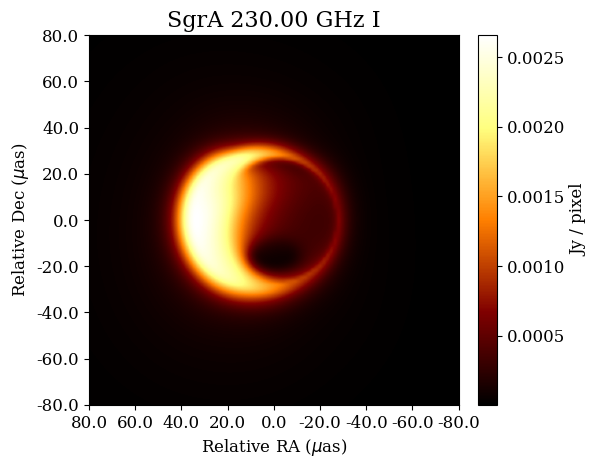

In [ ]:

image_path = 'datasets/avery_sgra_eofn.txt'
array_path = 'datasets/EHT2017.txt'
image_true = eh.image.load_txt(image_path)
image_true.display()

intensity_gt = jnp.array(image_true.imarr(), dtype=jnp.float32)
ydim, xdim = intensity_gt.shape
assert intensity_gt.size == image_true.imvec.size

x, y = np.linspace(0, 1, xdim), np.linspace(0, 1, ydim)
coords = np.moveaxis(np.array(np.meshgrid(x, y, indexing='xy')), 0, -1)

coords_flat = coords.reshape(-1,2)
gt_flat = intensity_gt.ravel()
I_max = float(max(gt_flat))

In [238]:
def flattened_traversal(fn):
    def mask(data):
        flat = flax.traverse_util.flatten_dict(data)
        return flax.traverse_util.unflatten_dict({k: fn(k, v) for k, v in flat.items()})
    return mask

class MLP(nn.Module): 
    net_depth: int = 4
    net_width: int = 128
    activation: Callable[..., Any] = nn.relu 
    out_channel: int = 1
    do_skip: bool = True
  
    @nn.compact
    def __call__(self, x):
        """A simple Multi-Layer Preceptron (MLP) network

        Parameters
        ----------
        x: jnp.ndarray(float32), 
            [batch_size * n_samples, feature], points.
        net_depth: int, 
            the depth of the first part of MLP.
        net_width: int, 
            the width of the first part of MLP.
        activation: function, 
            the activation function used in the MLP.
        out_channel: 
            int, the number of alpha_channels.
        do_skip: boolean, 
            whether or not to use a skip connection

        Returns
        -------
        out: jnp.ndarray(float32), 
            [batch_size * n_samples, out_channel].
        """
        dense_layer = functools.partial(
            nn.Dense, kernel_init=jax.nn.initializers.he_uniform()) 

        if self.do_skip:
            skip_layer = self.net_depth // 2 

        inputs = x
        for i in range(self.net_depth): 
            x = dense_layer(self.net_width)(x)
            x = self.activation(x) 
            if self.do_skip:
                if i % skip_layer == 0 and i > 0:
                    x = jnp.concatenate([x, inputs], axis=-1)
        out = dense_layer(self.out_channel)(x)

        return out

def posenc(x, deg):
    """
    Concatenate `x` with a positional encoding of `x` with degree `deg`.
    Instead of computing [sin(x), cos(x)], we use the trig identity
    cos(x) = sin(x + pi/2) and do one vectorized call to sin([x, x+pi/2]).

    Parameters
    ----------
    x: jnp.ndarray, 
        variables to be encoded. Note that x should be in [-pi, pi].
    deg: int, 
        the degree of the encoding.

    Returns
    -------
    encoded: jnp.ndarray, 
        encoded variables.
    """
    if deg == 0:
        return x
    scales = jnp.array([2**i for i in range(deg)])
    xb = jnp.reshape((x[..., None, :] * scales[:, None]),
                     list(x.shape[:-1]) + [-1])
    four_feat = safe_sin(jnp.concatenate([xb, xb + 0.5 * jnp.pi], axis=-1)) 
    return jnp.concatenate([x] + [four_feat], axis=-1)

class NeuralImage(nn.Module):
    """
    Full function to predict emission at a time step.
    
    Parameters
    ----------
    posenc_deg: int, default=3
    net_depth: int, default=4
    net_width: int, default=128
    activation: Callable[..., Any], default=nn.relu
    out_channel: int default=1
    do_skip: bool, default=True
    """
    posenc_deg: int = 3
    net_depth: int = 4
    net_width: int = 128
    activation: Callable[..., Any] = nn.relu
    out_channel: int = 1
    do_skip: bool = True
    
    @nn.compact
    def __call__(self, coords):
        image_MLP = MLP(self.net_depth, self.net_width, self.activation, self.out_channel, self.do_skip)
        def predict_image(coords):
            net_output = image_MLP(posenc(coords, self.posenc_deg))
            image = I_max*nn.sigmoid(net_output[..., 0])

            return image
        return predict_image(coords)
    
safe_sin = lambda x: jnp.sin(x % (100 * jnp.pi))

In [273]:
def fourier_forward(image_pred, n_crop):
    """
    Predict the image in Fourier space and crop it in the center
    with dimensions n_crop x n_crop.

    Args:
        image_pred (jnp.ndarray(float32)): the predicted image
        n_crop (int): the size of the crop to take from the center of the Fourier transform
    Returns:
        F_c (jnp.ndarray(float32)): the cropped Fourier transform of the predicted image
    """
    F = jnp.fft.fftshift(jnp.fft.fft2(image_pred))
    cx = (image_pred.shape[1] - n_crop) // 2
    cy = (image_pred.shape[0] - n_crop) // 2
    F_c = jax.lax.dynamic_slice(F, start_indices=(cy, cx), slice_sizes=(n_crop, n_crop))
    return F_c.ravel()


def loss_fn(params, predictor_fn, target, sigma_vis, coords, n_crop):
    '''
    Args:
        params: pytree (nested dict) of all of the model's weights and biases. 
        predictor_fn: the model's apply function
        target: measured intensities
        A: measurement matrix
        sigma: Thermal noise per visibility
        coords: array of shape (N_pixels, 2) with all (x,y) grid coords
    
    Returns:
        image: predicted intensities -> image
        loss: 
    '''
    image_pred = predictor_fn({'params': params}, coords)
    vis = fourier_forward(image_pred, n_crop)
    loss = jnp.mean((jnp.abs(vis - target)/sigma_vis)**2)
    return loss, image_pred

@functools.partial(jax.jit, static_argnums=(4,))
def train_step(state, target, sigma_vis, coords, n_crop):
    (loss, image), grads = jax.value_and_grad(loss_fn, argnums=(0), has_aux=True)(state.params, state.apply_fn, target, sigma_vis, coords, n_crop)
    state = state.apply_gradients(grads=grads)
    return loss, state, image

predictor = NeuralImage()

In [316]:
"""
Training loop
"""
npix = 100
n_crop = 5
rng_real, rng_im = jax.random.PRNGKey(2), jax.random.PRNGKey(3)

vis_true = fourier_forward(intensity_gt, n_crop)
hetero = True
if hetero:
    sigma_vis = jnp.linspace(1e-3, 1e-2, vis_true.size, dtype=jnp.float32)  # linear noise
else:
    sigma_vis = 1e-2 * jnp.ones_like(vis_true, dtype=jnp.float32) #constant noise
vis_obs = vis_true + sigma_vis * (jax.random.normal(rng_real, vis_true.shape) + 1j*jax.random.normal(rng_im, vis_true.shape)) / jnp.sqrt(2)
print(vis_true.shape)
print(vis_obs.shape)
#x, y = np.linspace(0, 1, xdim, endpoint=False), np.linspace(0, 1, ydim, endpoint=False)
#coords = np.moveaxis(np.array(np.meshgrid(x, y, indexing='ij')), 0, -1)

hparams = {'num_iters': 4000, 'lr_init': 1e-3, 'lr_final': 1e-3, 'batchsize': 500}
params = predictor.init(jax.random.PRNGKey(1), coords)['params']
tx = optax.adam(learning_rate=hparams['lr_init'])
state = train_state.TrainState.create(apply_fn=predictor.apply, params=params, tx=tx)

for i in tqdm(range(hparams['num_iters']), desc='iteration'):
    #batch = np.random.choice(vis_obs.size, hparams['batchsize'], replace=False)
    loss, state, image = train_step(state, vis_obs, sigma_vis, coords, n_crop)
    if i % 1000 == 0:
        print(f"iteration {i}, loss={loss:.5f}")

(25,)
(25,)


iteration:   0%|          | 0/4000 [00:00<?, ?it/s]

iteration 0, loss=152519.26562
iteration 1000, loss=0.13704
iteration 2000, loss=0.13734
iteration 3000, loss=0.13693


(100, 100)


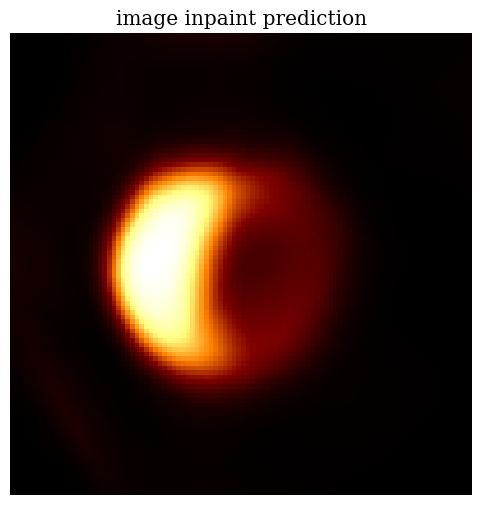

In [317]:
full_image = predictor.apply({'params': state.params}, coords)
full_image = np.array(full_image)
print(full_image.shape)
plt.figure(figsize=(6,6))
plt.imshow(full_image, cmap='afmhot', origin='upper')
plt.axis('off')
plt.title('image inpaint prediction')
plt.show()

In [318]:
def bilinear(coords, theta):
    """gpt generated function to fill in for now"""
    gx, gy, _ = theta.shape
    # scale to vertex index space
    x = coords[..., 0] * (gx - 1)
    y = coords[..., 1] * (gy - 1)

    i0 = jnp.floor(x).astype(jnp.int32)
    j0 = jnp.floor(y).astype(jnp.int32)
    i1 = jnp.clip(i0 + 1, 0, gx - 1)
    j1 = jnp.clip(j0 + 1, 0, gy - 1)

    wx = x - i0
    wy = y - j0

    # gather four corners
    t00 = theta[i0, j0]      # lower-left
    t10 = theta[i1, j0]      # lower-right
    t01 = theta[i0, j1]      # upper-left
    t11 = theta[i1, j1]      # upper-right

    return ((1 - wx) * (1 - wy))[..., None] * t00 + \
           (     wx  * (1 - wy))[..., None] * t10 + \
           ((1 - wx) *      wy )[..., None] * t01 + \
           (     wx  *      wy )[..., None] * t11

class DeformationGrid(nn.Module):
    resolution: tuple[int, ...]

    @nn.compact
    def __call__(self, coords):
        theta = self.param(
            'theta', 
            nn.initializers.zeros, 
            self.resolution + (coords.shape[-1],)
        )
        return bilinear(coords, theta)

def forward_with_deform(params_img, params_def, coords):
    offsets = DeformationGrid.apply({'params': params_def}, coords)
    return predictor.apply({'params': params_img}, coords + offsets)

grid_res = (64, 64)
def_grid = DeformationGrid(grid_res)

In [319]:
'''prepare parameter variables for bayes rays'''

params_img = state.params
params_img_frozen = jax.tree_util.tree_map(jnp.array, params_img)

params_def = def_grid.init(
    jax.random.PRNGKey(0), 
    jnp.array([[0, 0]]))['params']
params_def = jax.tree_util.tree_map(jnp.zeros_like, params_def)
nvis = n_crop * n_crop

In [322]:
def forward_visibility(params_def, coords):
    """
    add offset and get updated visibility matrix
    """
    offsets = def_grid.apply({'params': params_def}, coords)
    img_pred = predictor.apply({'params': params_img_frozen}, coords + offsets)
    return fourier_forward(img_pred, n_crop)

# compute derivatives of real and imaginary parts independently otherwise H not differentiable
def re_vis(params_def, k):
    """Re(eps_theta(r))"""
    return jnp.real(forward_visibility(params_def, coords)[k])

def im_vis(params_def, k):
    """Im(eps_theta(r))"""
    return jnp.imag(forward_visibility(params_def, coords)[k])

#sigma = jnp.asarray(sigma) # for jit compilation

#take the gradient of a forward_visibility (real or imaginary) over k visibilities
def grad_row(fn, k):
    g_tree = jax.grad(fn)(params_def, k)
    return g_tree['theta']

# compute hessian in chunks
@functools.partial(jax.jit, static_argnums=(1,))
def chunk(idx, fn, sigma_batch):
    jacobian = jax.vmap(lambda k: grad_row(fn, k))(idx) # evaluate grad_row over each i \in idx
    sigma = sigma_batch.reshape((-1,) + (1,)*(jacobian.ndim-1))
    jacobian = jacobian / (sigma/jnp.sqrt(2))  # Normalize by sigma_n^2
    return jnp.sum(jacobian**2, axis=0)

def fisher_sum(chunk_size, res):
    """
    Can no longer assume sigma^2 = 1/2 or use abs in loss fn. Take the derivative of the real and imaginary parts
    and compute in chunks of rows to avoid OOM. 
    
    Args:
        chunk_size: number of rows of the jacobian to evaluate in one step
        res: grid resolution, (xdim, ydim); 2D for now
    Returns:
        J_sq: = sum( (J_re_n^2 + J_im_n^2) / sigma_n^2)
    """
    J_sq = jnp.zeros((res[0], res[1], 2))
    rows_acc = 0
    for start in range(0, nvis, chunk_size):
        end = min(start+chunk_size, nvis)
        idx = jnp.arange(start, end)

        J_sq += chunk(idx, re_vis, sigma_vis[idx]) + chunk(idx, im_vis, sigma_vis[idx])
        rows_acc += end - start
    return J_sq, rows_acc

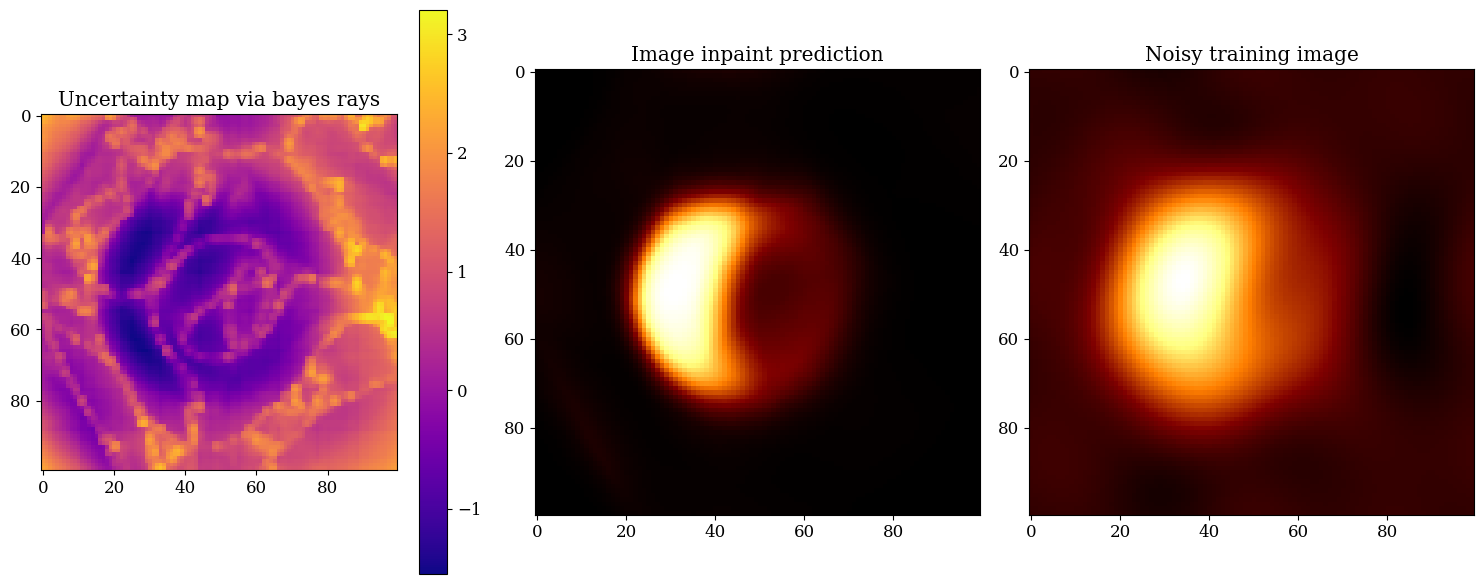

In [323]:
def vis_to_image(vis_vec, n_crop, full_N=100):
    uv = np.zeros((full_N, full_N), dtype=np.complex64)
    cx = (full_N - n_crop) // 2
    cy = (full_N - n_crop) // 2
    uv[cy:cy+n_crop, cx:cx+n_crop] = vis_vec.reshape(n_crop, n_crop)
    return np.fft.ifft2(np.fft.ifftshift(uv)).real

chunk_size = 32
J_sq, rows_acc = fisher_sum(chunk_size, grid_res)
assert rows_acc == nvis

lam = 1e-4/(grid_res[0]*grid_res[1])
H_diag = (4*J_sq)/(nvis) + 2.0*lam # deterministic H, no monte carlo
variance_grid = 1 / H_diag
sigma_map = jnp.linalg.norm(
    jnp.sqrt(bilinear(coords, variance_grid)), 
    axis=-1
)

full_image = predictor.apply({'params': state.params}, coords)
full_image = np.array(full_image)

fig, ax = plt.subplots(1, 3, figsize=(15,6))
im_0 = ax[0].imshow(jnp.log10(sigma_map + 1e-12), cmap='plasma', origin="upper")
ax[0].set_title("Uncertainty map via bayes rays")
im_1 = ax[1].imshow(full_image, cmap='afmhot', origin='upper')
ax[1].set_title('Image inpaint prediction')
im_2 = ax[2].imshow(vis_to_image(vis_obs, n_crop), cmap='afmhot', origin='upper')
ax[2].set_title('Noisy training image')
plt.tight_layout()
fig.colorbar(im_0, ax=ax[0])